<a href="https://colab.research.google.com/github/th2l-aipn/IntroDL/blob/master/examples/2.%20CNN%20%2B%20MLP/3_Emotion_Reg_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
```
> Nguyen Hai Duong
> nhduong_3010@live.com
> Modified: Huynh Van Thong
> hvthong.298@gmail.com
> Chonnam National University
```
---

## Overview
- FER2013 dataset (face images + facial expression)
  + Goal: classifying facial exprression
  + Input: a 48x48 image
  + Output: facial expression (angry, disgust, fear, happy, neutral, sad, and surprise)
- Defining an CNN+MLP
- Training and evaluating an CNN+MLP

## Import libraries

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
num_classes = 7   # angry, disgust, fear, happy, neutral, sad, and surprise

## 1. Data

In [3]:
# Download dataset
import requests
url1 = 'https://www.dropbox.com/s/w83gf8celxccdwi/fer2013_publictest_onehot.csv?dl=1'
url2 = 'https://www.dropbox.com/s/rmpvvvt22nqrcd8/fer2013_training_onehot.csv?dl=1'
url3 = 'https://www.dropbox.com/s/pten8miyvuhxgsu/fer2013_weights.h5?dl=1'
url4 = 'https://www.dropbox.com/s/1yw4anh8zm5o4bv/fer2013.h5?dl=1'

r1 = requests.get(url1, allow_redirects=True)
open('fer2013_publictest_onehot.csv', 'wb').write(r1.content)

r2 = requests.get(url2, allow_redirects=True)
open('fer2013_training_onehot.csv', 'wb').write(r2.content)

r3 = requests.get(url3, allow_redirects=True)
open('fer2013_weights.h5', 'wb').write(r3.content)

r4 = requests.get(url4, allow_redirects=True)
open('fer2013.h5', 'wb').write(r4.content)

!ls

fer2013.h5		       fer2013_training_onehot.csv  sample_data
fer2013_publictest_onehot.csv  fer2013_weights.h5


In [4]:
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')

trainingset

array([[ 70.,  80.,  82., ...,   0.,   0.,   0.],
       [151., 150., 147., ...,   0.,   0.,   0.],
       [231., 212., 156., ...,   0.,   0.,   0.],
       ...,
       [ 74.,  81.,  87., ...,   1.,   0.,   0.],
       [222., 227., 203., ...,   0.,   0.,   0.],
       [195., 199., 205., ...,   1.,   0.,   0.]])

In [5]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=4)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app


## 2. Declare model

In [6]:
# 64x64 portray image
input_image = Input(shape=(48, 48, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.25, name='conv_dropout1')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = Conv2D(filters=218, kernel_size=(3, 3), padding='valid', activation='relu', name='conv2_4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.25, name='conv_dropout2')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='fc_dropout1')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_7ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='emo_cnn')

# print model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 48, 48, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 46, 46, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 23, 23, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)     

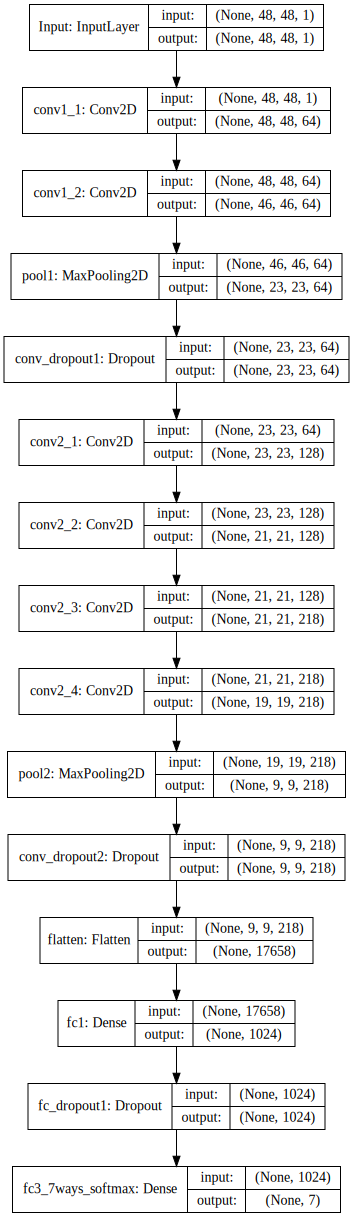

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 3. Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [8]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.0001
model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=['accuracy'])

# train the model
batch_size = 128
epochs = 15

starting_time = time.time()
history = model.fit(x_training, y_training,
                    validation_data=(x_testing, y_testing),
                    batch_size=batch_size,
                    epochs=epochs)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 3589 samples
Epoch 1/15
28709/28709 [==============================] - 28s 958us/step - loss: 2.8359 - acc: 0.2458 - val_loss: 1.7196 - val_acc: 0.3435
Epoch 2/15
28709/28709 [==============================] - 21s 726us/step - loss: 1.6353 - acc: 0.3646 - val_loss: 1.5248 - val_acc: 0.4082
Epoch 3/15
28709/28709 [==============================] - 21s 738us/step - loss: 1.5065 - acc: 0.4229 - val_loss: 1.3921 - val_acc: 0.4667
Epoch 4/15
28709/28709 [==============================] - 21s 747us/step - loss: 1.4080 - acc: 0.4630 - val_loss: 1.3394 - val_acc: 0.4954
Epoch 5/15
28709/28709 [==============================] - 22s 754us/step - loss: 1.3127 - acc: 0.5003 - val_loss: 1.2682 - val_acc: 0.5222
Epoch 6/15
28709/28709 [==============================] - 22s 763us/step - loss: 1.2227 - acc: 0.5388 - val_loss: 1.2402 - val_acc: 0.5277
Epoch 7/15
28709/28709 [==============================] - 22s 770us/s

In [9]:
!nvidia-smi

Mon Jun  3 09:07:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |   2597MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Training time
- Training time with Tesla T4 is about 5.5981 minutes for 15 epochs
- Training time with Core i7 is around 302.6 minutes (~5.04 hours) for 15 epochs

## 4. Evaluate trained model

In [10]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3589/3589 [==============================] - 1s 328us/step
Test loss: 1.3526217216700025
Test accuracy: 0.5870716077233795


In [0]:
def get_emotion(ohv):
    indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

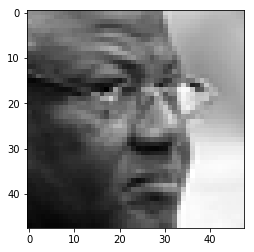

> testing image index: 528
> true emotion: sad
> predicted emotion: happy


In [12]:
# 2163
img_indx = np.uint32(np.random.rand()*(testingset.shape[0] - 1))
sample = x_testing[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict(sample.reshape(1, 48, 48, 1))

plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_testing[img_indx, :]), get_emotion(pred_cls)))